In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

from src.geometry import (
    compute_distance_from_homography,
    derive_metric_homography,
)
from src.matching import template_match
from src.measurement_data import Scene, Template, load_measurements_from_yaml
from src.utils import load_calibration_json

In [3]:
# Load measurement data
data = load_measurements_from_yaml("../assets/measurements.yaml")

# Load camera calibration
K, dist_coeffs, image_size = load_calibration_json("../assets/camera_calibration.json")

# Collect all scenes from the measurement data
scenes = data.get_all_scenes()

In [4]:
class DistanceVisualizationError(Exception):
    """Custom exception for distance visualization errors."""
    pass


def validate_inputs(
    scene_id: str,
    scenes: dict[str, list[str]],
    K: np.ndarray,
    mesh_spacing_mm: float
) -> None:
    """Validate input parameters."""
    if scene_id not in scenes:
        raise DistanceVisualizationError(f"Scene ID '{scene_id}' not found in scenes dictionary")
    
    if not scenes[scene_id]:
        raise DistanceVisualizationError(f"No templates found for scene '{scene_id}'")
    
    if not isinstance(K, np.ndarray) or K.shape != (3, 3):
        raise DistanceVisualizationError("Camera intrinsic matrix K must be a 3x3 numpy array")
    
    if np.linalg.det(K) == 0:
        raise DistanceVisualizationError("Camera intrinsic matrix K is singular")
    
    if mesh_spacing_mm <= 0:
        raise DistanceVisualizationError("mesh_spacing_mm must be positive")


def load_scene_image(scene_path: str) -> np.ndarray:
    """Safely load scene image with error handling."""
    if not os.path.exists(scene_path):
        raise DistanceVisualizationError(f"Scene image not found: {scene_path}")
    
    try:
        img = plt.imread(scene_path)
        if img is None or img.size == 0:
            raise DistanceVisualizationError(f"Failed to load image or image is empty: {scene_path}")
        return img
    except Exception as e:
        raise DistanceVisualizationError(f"Error loading scene image {scene_path}: {str(e)}")


def validate_template_dimensions(template: Template) -> tuple[float, float]:
    """Validate template has positive dimensions."""
    width_mm, height_mm = template.width, template.height
    if width_mm <= 0 or height_mm <= 0:
        raise DistanceVisualizationError(
            f"Template {template.id} has invalid dimensions: {width_mm}x{height_mm} mm"
        )
    return width_mm, height_mm


def compute_homography_with_validation(template_path: str, scene_path: str) -> tuple[np.ndarray, tuple[int, int]]:
    """Compute homography with quality validation."""
    if not os.path.exists(template_path):
        raise DistanceVisualizationError(f"Template image not found: {template_path}")
    
    try:
        H_px, mask, t_shape = template_match(
            template_path, scene_path,
            extract_method='SIFT', match_method='BF', plot=False
        )
    except Exception as e:
        raise DistanceVisualizationError(f"Template matching failed: {str(e)}")
    
    if H_px is None:
        raise DistanceVisualizationError("Homography computation failed - insufficient matches found")
    
    # Validate homography quality
    if mask is not None:
        inlier_ratio = np.sum(mask) / len(mask) if len(mask) > 0 else 0
        if inlier_ratio < 0.3:  # Less than 30% inliers
            warnings.warn(f"Low homography quality: {inlier_ratio:.1%} inliers", UserWarning)
    
    # Check if homography is reasonable (not too distorted)
    det = np.linalg.det(H_px[:2, :2])
    if abs(det) < 1e-6:
        raise DistanceVisualizationError("Homography is degenerate (near-singular)")
    
    return H_px, t_shape


def safe_homogeneous_division(points: np.ndarray) -> np.ndarray:
    """Safely perform homogeneous coordinate division with handling for points at infinity."""
    if points.shape[-1] != 3:
        raise ValueError("Points must be in homogeneous coordinates (shape [..., 3])")
    
    # Check for points at or near infinity
    z_coords = points[..., 2]
    near_infinity_mask = np.abs(z_coords) < 1e-10
    
    if np.any(near_infinity_mask):
        warnings.warn(f"Found {np.sum(near_infinity_mask)} points at or near infinity", UserWarning)
    
    # Set very small z coordinates to a small positive value to avoid division by zero
    z_coords_safe = np.where(np.abs(z_coords) < 1e-10, 1e-10, z_coords)
    
    result = np.zeros_like(points[..., :2])
    result[..., 0] = points[..., 0] / z_coords_safe
    result[..., 1] = points[..., 1] / z_coords_safe
    
    return result, ~near_infinity_mask


def compute_template_distances(
    template: Template,
    H_px: np.ndarray,
    H_metric: np.ndarray,
    t_shape: tuple[int, int],
    mesh_spacing_mm: float,
    K: np.ndarray
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute distances and pixel coordinates for a template mesh using pre-computed H_metric.
    
    This version takes H_metric as input to avoid recomputing it and ensure numerical consistency.
    """
    width_mm, height_mm = validate_template_dimensions(template)
    height_px, width_px = t_shape
    
    # Generate mesh with constant spacing in template metric space
    # Calculate number of divisions based on constant spacing
    width_divs = max(2, int(np.ceil(width_mm / mesh_spacing_mm)) + 1)
    height_divs = max(2, int(np.ceil(height_mm / mesh_spacing_mm)) + 1)
    
    xs_mm = np.linspace(0, width_mm, width_divs)
    ys_mm = np.linspace(0, height_mm, height_divs)
    mesh_points = np.array([[x, y] for y in ys_mm for x in xs_mm])  # (N, 2)
    
    distances = []
    pixel_coords = []
    valid_points = []
    
    for i, (x_mm, y_mm) in enumerate(mesh_points):
        try:
            # Predict distance using the SAME H_metric
            dist = compute_distance_from_homography(
                H_mm2img=H_metric,
                K=K,
                point_mm=(x_mm, y_mm)  # Convert to tuple format
            )
            
            # Validate distance is reasonable
            if dist <= 0 or dist > 1e6:  # Reject negative or extremely large distances
                continue
                
            distances.append(dist)
            
            # Map mm -> template px -> scene px
            u = (x_mm / width_mm) * width_px
            v = (y_mm / height_mm) * height_px
            pt = np.array([u, v, 1.0])
            
            proj = H_px @ pt
            pixel_coord, is_valid = safe_homogeneous_division(proj.reshape(1, -1))
            
            if is_valid[0]:
                pixel_coords.append(pixel_coord[0])
                valid_points.append(i)
            
        except Exception as e:
            # Log warning but continue processing other points
            warnings.warn(f"Failed to process mesh point ({x_mm:.1f}, {y_mm:.1f}): {str(e)}", UserWarning)
            continue
    
    if not distances:
        raise DistanceVisualizationError(f"No valid distance estimates found for template {template.id}")
    
    return np.array(pixel_coords), np.array(distances), np.array(valid_points)


def compute_center_error(template: Template, H_metric: np.ndarray, K: np.ndarray, scene: Scene) -> float:
    """Compute and return center point error percentage."""
    try:
        width_mm, height_mm = validate_template_dimensions(template)
        center_mm = np.array([width_mm/2, height_mm/2])
        
        dist_pred_center = compute_distance_from_homography(
            H_mm2img=H_metric, K=K, point_mm=center_mm
        )
        
        true_distance = scene.get_distance('Camera', template.id).distance
        if true_distance <= 0:
            warnings.warn(f"Invalid true distance for template {template.id}: {true_distance}", UserWarning)
            return float('inf')
        
        error_pct = abs(dist_pred_center - true_distance) / true_distance * 100

        print

        return error_pct
        
    except Exception as e:
        warnings.warn(f"Failed to compute center error for template {template.id}: {str(e)}", UserWarning)
        return float('inf')


def display_scene(
    scene_id: str,
    scenes: dict[str, list[str]],
    K: np.ndarray,
    mesh_spacing_mm: float = 5.0,
    cmap: str = 'viridis',
    scatter_size: int = 20,
    scatter_alpha: float = 0.8,
    figsize: tuple[int, int] = (12, 9)
) -> plt.Figure | None:
    """
    Display a scene with colored scatter mesh overlay of distance estimates for each template.

    Parameters:
    - scene_id: identifier for the target scene image
    - scenes: dict mapping scene_id to list of template_ids
    - K: camera intrinsic matrix (3x3)
    - mesh_spacing_mm: constant spacing between mesh points in millimeters (determines mesh density)
    - cmap: matplotlib colormap name for distance coloring
    - scatter_size: size of scatter points
    - scatter_alpha: transparency of scatter points
    - figsize: figure size tuple

    Returns:
    - matplotlib Figure object, or None if visualization failed

    Raises:
    - DistanceVisualizationError: for various input validation and processing errors
    """
    
    # Input validation
    validate_inputs(scene_id, scenes, K, mesh_spacing_mm)
    
    try:
        # Load scene and templates
        scene = data.get_scene(scene_id)
        template_ids = scenes[scene_id]
        templates = []
        
        for t_id in template_ids:
            try:
                template = data.get_template(t_id)
                templates.append(template)
            except Exception as e:
                warnings.warn(f"Failed to load template {t_id}: {str(e)}", UserWarning)
                continue
        
        if not templates:
            raise DistanceVisualizationError("No valid templates could be loaded")
        
        scene_path = os.path.join(project_root, scene.path)
        
        # Load and validate scene image
        img = load_scene_image(scene_path)
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        ax.imshow(img)
        ax.axis('off')
        
        # Track all distances for consistent colorbar
        all_distances = []
        template_results = []
        
        # Process each template
        successful_templates = 0
        for template in templates:
            try:
                template_path = os.path.join(project_root, template.path)
                
                # Compute homography with validation
                H_px, t_shape = compute_homography_with_validation(template_path, scene_path)
                
                # Extract template dimensions and derive metric homography ONCE
                width_mm, height_mm = validate_template_dimensions(template)
                height_px, width_px = t_shape
                
                H_metric = derive_metric_homography(
                    H_px=H_px,
                    template_size_px=(height_px, width_px),
                    template_size_metric=(height_mm, width_mm)
                )
                
                # Compute distances and pixel coordinates using the SAME H_metric
                pixel_coords, distances, valid_indices = compute_template_distances(
                    template, H_px, H_metric, t_shape, mesh_spacing_mm, K
                )
                
                # Filter points that fall outside image bounds
                img_height, img_width = img.shape[:2]
                in_bounds = ((pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < img_width) &
                           (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < img_height))
                
                pixel_coords = pixel_coords[in_bounds]
                distances = distances[in_bounds]
                
                if len(distances) == 0:
                    warnings.warn(f"No valid points found for template {template.id}", UserWarning)
                    continue
                
                # Store results with the SAME H_metric for error calculation
                template_results.append((template, pixel_coords, distances, H_metric))
                all_distances.extend(distances)
                successful_templates += 1
                
            except DistanceVisualizationError:
                raise  # Re-raise critical errors
            except Exception as e:
                warnings.warn(f"Failed to process template {template.id}: {str(e)}", UserWarning)
                continue
        
        if successful_templates == 0:
            raise DistanceVisualizationError("No templates could be successfully processed")
        
        # Determine consistent color scale
        if all_distances:
            vmin, vmax = np.min(all_distances), np.max(all_distances)
        else:
            vmin, vmax = 0, 1000  # Default range
        
        # Plot all templates with consistent color scale
        scatter_collection = None
        for template, pixel_coords, distances, H_metric in template_results:
            sc = ax.scatter(
                pixel_coords[:, 0], pixel_coords[:, 1],
                c=distances, cmap=cmap, s=scatter_size, alpha=scatter_alpha,
                vmin=vmin, vmax=vmax
            )
            scatter_collection = sc  # Keep reference for colorbar
            
            # Compute center error using the SAME H_metric that was used for mesh computation
            try:
                width_mm, height_mm = validate_template_dimensions(template)
                center_mm = np.array([width_mm/2, height_mm/2], dtype=np.float32)
                
                dist_pred_center = compute_distance_from_homography(
                    H_mm2img=H_metric,
                    K=K,
                    point_mm=(center_mm[0], center_mm[1])  # Convert to tuple format
                )
                
                true_distance = scene.get_distance('Camera', template.id).distance
                if true_distance > 0:
                    error_pct = abs(dist_pred_center - true_distance) / true_distance * 100
                    print(f"Template {template.id}: center error = {error_pct:.2f}%")
                else:
                    warnings.warn(f"Invalid true distance for template {template.id}: {true_distance}", UserWarning)
                    
            except Exception as e:
                warnings.warn(f"Could not compute center error for template {template.id}: {str(e)}", UserWarning)
        
        # Add colorbar
        if scatter_collection is not None:
            cbar = fig.colorbar(scatter_collection, ax=ax, fraction=0.036, pad=0.04)
            cbar.set_label('Distance (mm)', fontsize=12)
        
        plt.title(f"Scene {scene_id}: Distance Mesh Overlay ({successful_templates} templates)", 
                 fontsize=14, pad=20)
        plt.tight_layout()
        
        return fig
        
    except DistanceVisualizationError:
        raise  # Re-raise our custom errors
    except Exception as e:
        raise DistanceVisualizationError(f"Unexpected error in display_scene: {str(e)}")


# Convenience function for quick visualization with error handling
def safe_display_scene(*args, **kwargs) -> bool:
    """
    Safe wrapper for display_scene that handles all exceptions.
    
    Returns:
    - True if visualization succeeded, False otherwise
    """
    try:
        fig = display_scene(*args, **kwargs)
        if fig is not None:
            plt.show()
            return True
        return False
    except Exception as e:
        print(f"Visualization failed: {str(e)}")
        return False

Template T1: center error = 0.44%
Template T0: center error = 3.11%


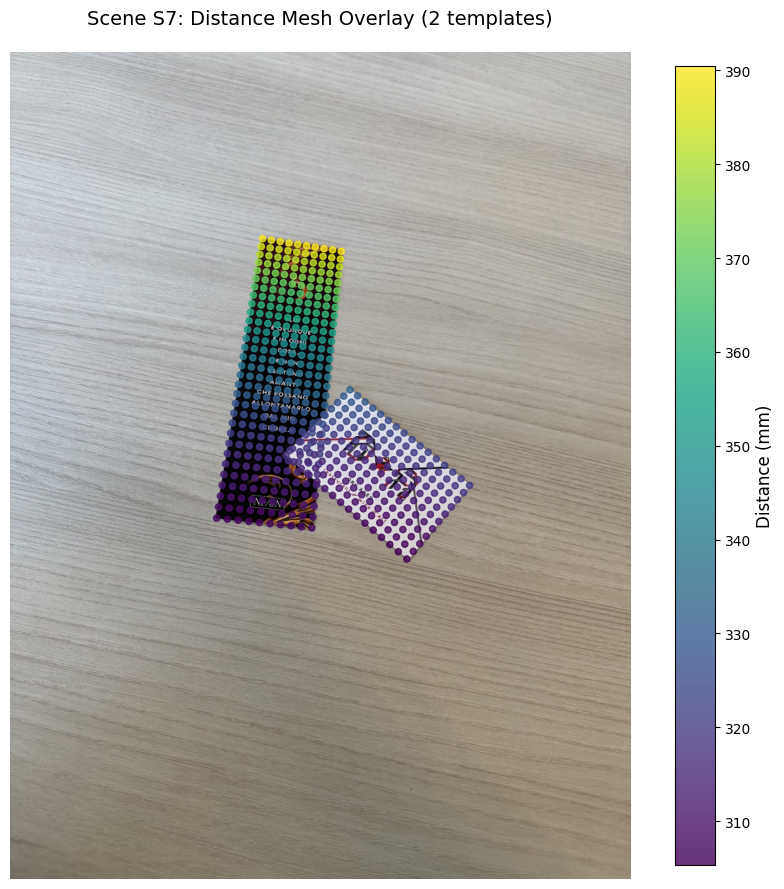

In [12]:
# Display a scene
scene_id = "S7"
safe_display_scene(
    scene_id=scene_id,
    scenes=scenes,
    K=K,
    mesh_spacing_mm=6.0,
    cmap='viridis',
    scatter_size=20,
    scatter_alpha=0.8,
    figsize=(12, 9)
);